In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your data
data = pd.read_csv('Cherapunjee_mon.csv')
data = data.ffill()  # Using forward fill

data.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1872,13.0,8.9,294.4,735.3,879.1,2632.7,3277.9,1359.9,2577.8,348.5,9.4,0.0
1,1873,5.3,105.2,290.8,455.7,339.3,2256.0,1804.4,1338.8,551.9,24.6,0.0,16.0
2,1874,27.2,118.4,278.6,719.6,2449.3,1632.5,2923.5,1152.1,1218.2,204.0,9.4,0.0
3,1875,70.4,20.1,176.3,1380.5,578.6,3407.7,2237.5,2128.5,365.8,12.7,0.0,0.0
4,1876,0.0,41.4,446.3,810.5,1368.0,4693.9,2016.0,1651.5,493.5,400.3,0.0,0.0


In [2]:
start_date = str(data.iloc[0,0])+'-01-01'
end_date = '2008-12-01'  # Adjust as necessary

# Create a date range for the first day of each month
dates = pd.date_range(start=start_date, end=end_date, freq='MS')
np.array(data.iloc[:,1:]).flatten(),dates

df = pd.DataFrame({
    'Date': dates,
    'Rainfall': np.array(data.iloc[:,1:]).flatten()
})
df.head()

,Date,Rainfall
0,1872-01-01,13.0
1,1872-02-01,8.9
2,1872-03-01,294.4
3,1872-04-01,735.3
4,1872-05-01,879.1


In [3]:
print(df.columns)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

Index(['Date', 'Rainfall'], dtype='object')


Text(0, 0.5, 'Rainfall (mm)')

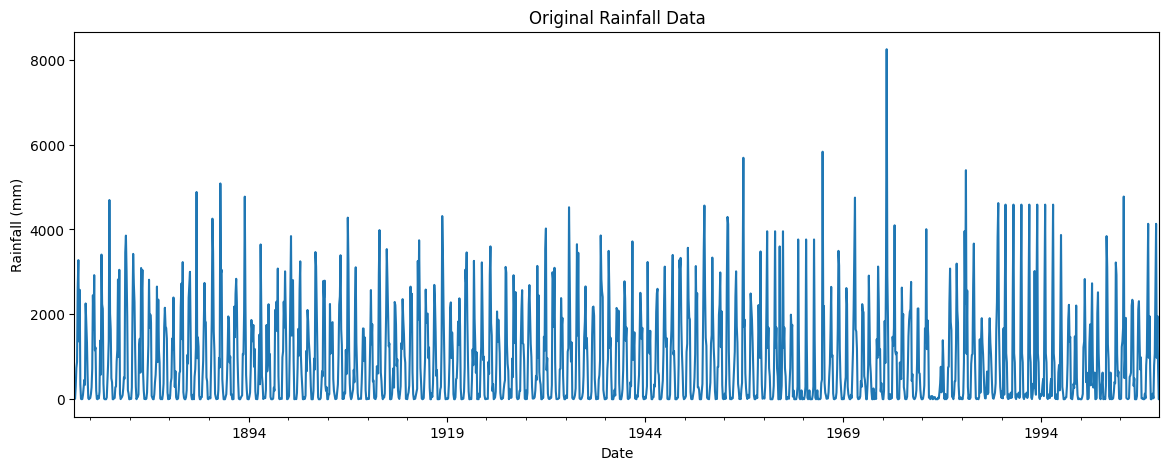

In [4]:
import matplotlib.pyplot as plt

df['Rainfall'].plot(title='Original Rainfall Data',figsize=(14,5))
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')

In [5]:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(ts):
    result = adfuller(ts)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    
check_stationarity(df['Rainfall'])

ADF Statistic: -6.8928135139744064
p-value: 1.342113540732391e-09


In [6]:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

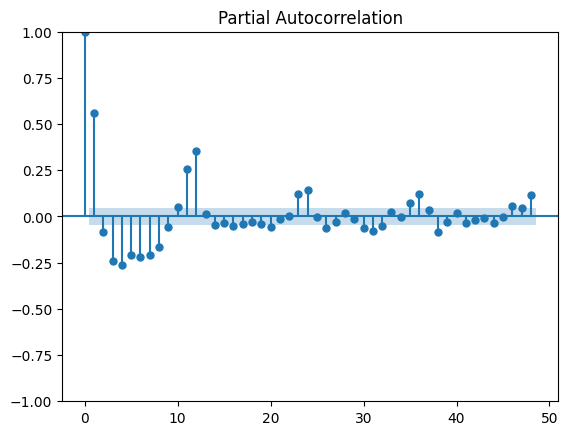

In [7]:
pacf = plot_pacf(df['Rainfall'],lags=12*4)

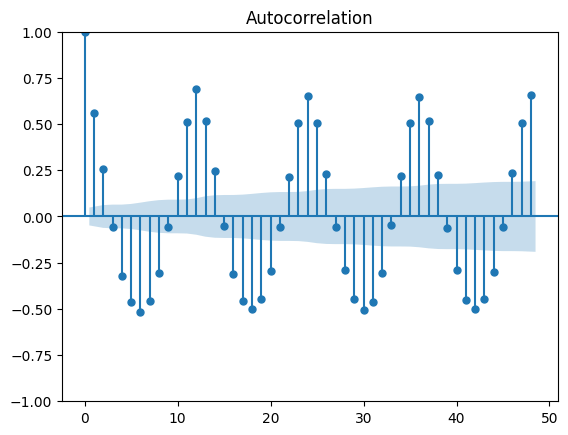

In [8]:
acf = plot_acf(df['Rainfall'],lags=12*4)

In [9]:
lags = [1, 11, 12, 23, 24, 35,36]
for lag in lags:
    df[f'lag_{lag}'] = df['Rainfall'].shift(lag)

In [10]:
df.dropna(inplace=True)


In [11]:
df.head()

,Rainfall,lag_1,lag_11,lag_12,lag_23,lag_24,lag_35,lag_36
Date,,,,,,,,
1875-01-01,70.4,0.0,118.4,27.2,105.2,5.3,8.9,13.0
1875-02-01,20.1,70.4,278.6,118.4,290.8,105.2,294.4,8.9
1875-03-01,176.3,20.1,719.6,278.6,455.7,290.8,735.3,294.4
1875-04-01,1380.5,176.3,2449.3,719.6,339.3,455.7,879.1,735.3
1875-05-01,578.6,1380.5,1632.5,2449.3,2256.0,339.3,2632.7,879.1


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Dense, Dropout,Layer,LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [29]:
# Assuming df is your DataFrame with Rainfall and lagged features
# Step 1: Prepare the data
X = df.drop(columns='Rainfall').values  # Features (lagged values)
y = df['Rainfall'].values  # Target (Rainfall)
X.shape,y.shape

((1608, 7), (1608,))

In [30]:
print(df.head())
print(X,y)

            Rainfall   lag_1  lag_11  lag_12  lag_23  lag_24  lag_35  lag_36
Date                                                                        
1875-01-01      70.4     0.0   118.4    27.2   105.2     5.3     8.9    13.0
1875-02-01      20.1    70.4   278.6   118.4   290.8   105.2   294.4     8.9
1875-03-01     176.3    20.1   719.6   278.6   455.7   290.8   735.3   294.4
1875-04-01    1380.5   176.3  2449.3   719.6   339.3   455.7   879.1   735.3
1875-05-01     578.6  1380.5  1632.5  2449.3  2256.0   339.3  2632.7   879.1
[[   0.   118.4   27.2 ...    5.3    8.9   13. ]
 [  70.4  278.6  118.4 ...  105.2  294.4    8.9]
 [  20.1  719.6  278.6 ...  290.8  735.3  294.4]
 ...
 [1958.     0.   728.  ...   27.     0.   490. ]
 [ 728.     0.     0.  ...    7.     0.     0. ]
 [   0.    48.     0.  ...    0.     0.     0. ]] [ 70.4  20.1 176.3 ... 728.    0.    0. ]


In [31]:
# Step 2: Split the data into train and test sets (90% train, 10% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [32]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((1447, 7), (1447,), (161, 7), (161,))

In [33]:
# Initialize scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

# Transform the testing data using the same scaler (fit on train data)
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

X_train_scaled[0:5],y_train_scaled[0:5]

(array([[0.17369684, 0.        , 0.10977591, 0.13028084, 0.24109958,
         0.066159  , 0.37332056],
        [0.31126543, 0.0241427 , 0.04151913, 0.00579619, 0.13973905,
         0.09899597, 0.13591939],
        [0.23257888, 0.23915943, 0.35425862, 0.36127953, 0.37800116,
         0.2272154 , 0.1635786 ],
        [0.01812414, 0.13542222, 0.00930058, 0.09911723, 0.00455934,
         0.14568075, 0.01345977],
        [0.00240055, 0.04547218, 0.02158413, 0.00897318, 0.00257069,
         0.03936072, 0.01326575]]),
 array([[0.07204006],
        [0.0572222 ],
        [0.25754232],
        [0.02547655],
        [0.00485037]]))

In [34]:
# Reshape the data for LSTM
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

X_train_scaled[0:5]

array([[[0.17369684, 0.        , 0.10977591, 0.13028084, 0.24109958,
         0.066159  , 0.37332056]],

       [[0.31126543, 0.0241427 , 0.04151913, 0.00579619, 0.13973905,
         0.09899597, 0.13591939]],

       [[0.23257888, 0.23915943, 0.35425862, 0.36127953, 0.37800116,
         0.2272154 , 0.1635786 ]],

       [[0.01812414, 0.13542222, 0.00930058, 0.09911723, 0.00455934,
         0.14568075, 0.01345977]],

       [[0.00240055, 0.04547218, 0.02158413, 0.00897318, 0.00257069,
         0.03936072, 0.01326575]]])

In [ ]:
# Define LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1,activation='relu'))  # Output layer for rainfall prediction

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Fit the model
model.fit(X_train_scaled, y_train, epochs=200, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)


Epoch 1/200


C:\Users\LALHRIEMSANG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1903852.8750 - val_loss: 2067400.0000
Epoch 2/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2006490.0000 - val_loss: 2066702.7500
Epoch 3/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1941134.0000 - val_loss: 2065420.7500
Epoch 4/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1961448.0000 - val_loss: 2063224.0000
Epoch 5/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2116495.5000 - val_loss: 2059819.2500
Epoch 6/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1898669.1250 - val_loss: 2055033.0000
Epoch 7/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2183885.7500 - val_loss: 2048518.8750
Epoch 8/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1937586.6250 - val_loss: 2040690.5000
Epoch 9/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2028955.0000 - val_loss: 2031050.6250
Epoch 10/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2085918.1250 - val_loss: 2020010.3750
Epoch 11/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 

In [28]:
# Evaluate on test set
test_loss = model.evaluate(X_test_scaled, y_test_scaled)
print("Test Loss:", test_loss)


ValueError: Cannot take the length of shape with unknown rank.